In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


# Transformação CIFAR100
## Baixa o Dataset pela biblioteca Pytorch e aplica um transform com normalização e redimensionamento

In [10]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# Caminhos relativos baseados em captcha/src → captcha/datasets/cifar100
train_dir = "../datasets/cifar100/train"
test_dir  = "../datasets/cifar100/val"

# Transformações aplicadas às imagens
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

# Dataset completo de treino/validação
full_trainset = ImageFolder(root=train_dir, transform=transform)

# Dividir em treino (80%) e validação (20%)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# Dataset de teste
testset = ImageFolder(root=test_dir, transform=transform)

# DataLoaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
valloader   = DataLoader(valset,   batch_size=64, shuffle=False, num_workers=1)
testloader  = DataLoader(testset,  batch_size=64, shuffle=False, num_workers=1)

# Informações
classes = full_trainset.classes
num_classes = len(classes)

print(f"Total de classes: {num_classes}")
print(f"Tamanho do treino: {len(trainset)}")
print(f"Tamanho da validação: {len(valset)}")
print(f"Tamanho do teste: {len(testset)}")


Total de classes: 100
Tamanho do treino: 32000
Tamanho da validação: 8000
Tamanho do teste: 8000


# Transformação do dataset GoogleRecaptchaV2 para os padrões ResNet, redimensionamento para 224x224 e normalização.

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torch
from torch.utils.data import DataLoader

# Transformações: resize para 224x224, normalização
transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Redimensionamento para 224x224
    transforms.ToTensor(),                        # Converte para tensor [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5),         # Normalização com médias e desvios padrões
                         (0.5, 0.5, 0.5))
])

# Defina o diretório local onde está o seu dataset
train_dir = "datasets/GRv2P/train"   # Substitua com o caminho para o diretório de treino
test_dir = "datasets/GRv2P/val"     # Substitua com o caminho para o diretório de teste

# Usando ImageFolder para carregar o dataset
trainset = ImageFolder(root=train_dir, transform=transform)
testset = ImageFolder(root=test_dir, transform=transform)

# Carregar os dados com DataLoader
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)

# Classes (rótulos) do dataset
classes = trainset.classes
num_classes = len(classes)

print(f"Classes: {classes}")
print(f"Classes: {num_classes}")


Classes: ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']
Classes: 12


In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

class TemporalResNet50(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(TemporalResNet50, self).__init__()
        
        # Backbone ResNet-50 sem o classificador final
        base_model = models.resnet50(weights='IMAGENET1K_V1')
        self.backbone = nn.Sequential(*list(base_model.children())[:-2])  # até a penúltima camada (sem avgpool e fc)
        
        # RNN-like: aplica-se LSTM nos mapas de características espaciais
        self.lstm = nn.LSTM(input_size=2048, hidden_size=256, num_layers=1, 
                            batch_first=True, bidirectional=True)

        # Classificador final
        self.classifier = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        x = self.backbone(x)          # [B, 2048, H, W], ex: [B, 2048, 2, 2] para input 64x64
        b, c, h, w = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]
        x = x.view(b, h * w, c)       # [B, T, C] onde T = H*W → sequência temporal

        x, _ = self.lstm(x)           # [B, T, 512]
        x = x[:, -1, :]               # último timestep
        x = self.classifier(x)
        return x


In [ ]:
import torch
from tqdm import tqdm

# Parâmetros
num_epochs = 200
patience = 15
melhor_val_acc = 0.0
epochs_sem_melhora = 0
melhor_modelo = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo e otimizador
model = TemporalResNet50(num_classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    loop = tqdm(trainloader, desc=f"[Epoch {epoch}] Treinando", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item())

    train_acc = 100 * correct / total
    avg_loss = total_loss / total

    # Validação
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    scheduler.step()

    print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Verifica se houve melhora na validação
    if val_acc > melhor_val_acc:
        melhor_val_acc = val_acc
        epochs_sem_melhora = 0
        melhor_modelo = model.state_dict()
        torch.save(melhor_modelo, "melhor_modelo.pth")
        print(f"📁 Modelo salvo em: melhor_modelo.pth")
        print(f"📈 Nova melhor Val Acc: {melhor_val_acc:.2f}% — salvando modelo.")
    else:
        epochs_sem_melhora += 1
        print(f"⏸️ Sem melhora há {epochs_sem_melhora} época(s).")

    if epochs_sem_melhora >= patience:
        print(f"🛑 Early stopping ativado! Nenhuma melhora por {patience} épocas.")
        break

# Restaurar melhor modelo (opcional)
model.load_state_dict(melhor_modelo)


Acurácia média por imagem: 71.70%


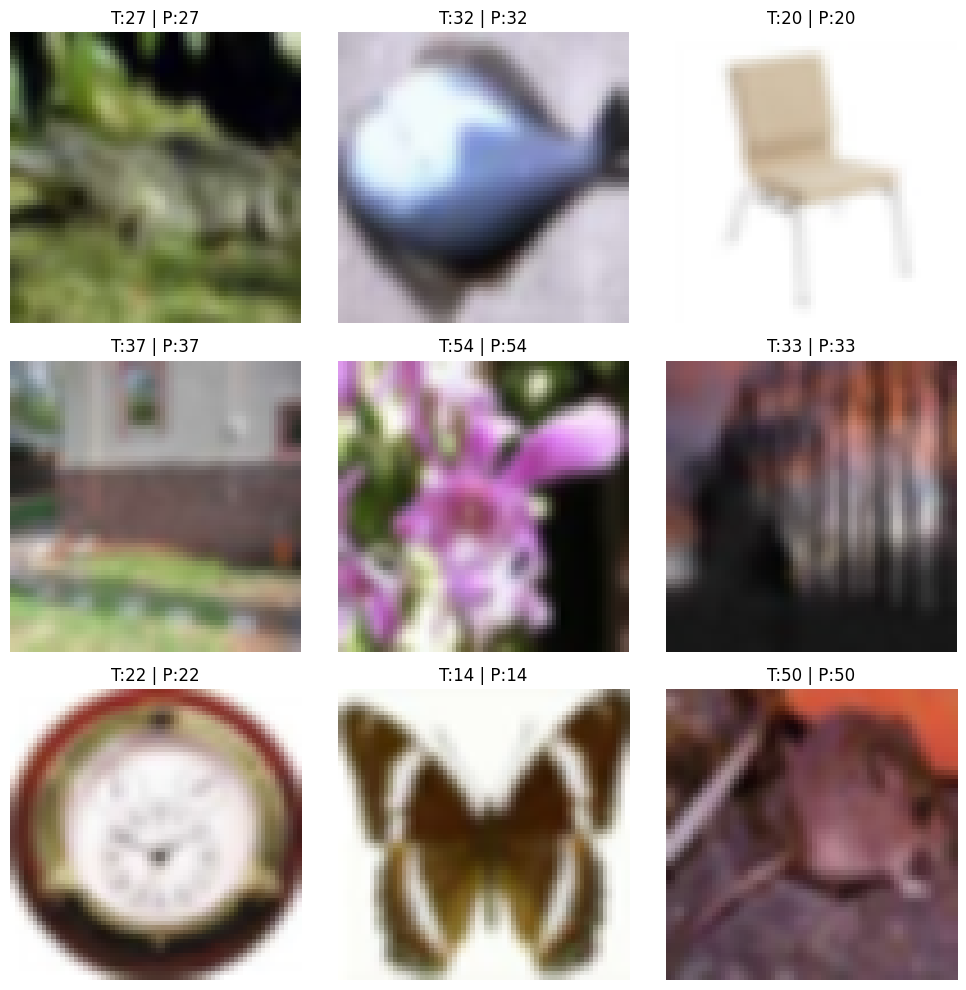

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Avaliação no conjunto de teste (acurácia média por imagem)
model.eval()
all_preds, all_labels, all_images = [], [], []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.append(images.cpu())

# Junta todas as imagens em um tensor
all_images = torch.cat(all_images, dim=0)

# Acurácia média por imagem
acc_media = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Acurácia média por imagem: {acc_media*100:.2f}%")

# Mostra um grid de 9 imagens aleatórias com label e predição
n_show = 9
idxs = np.random.choice(len(all_images), n_show, replace=False)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(idxs):
    img = all_images[idx]
    true_label = all_labels[idx]
    pred_label = all_preds[idx]

    # Desfaz normalização se aplicou (altere conforme sua normalização!)
    img_disp = img.permute(1, 2, 0).numpy()
    img_disp = (img_disp * 0.5) + 0.5  # se usou Normalize(mean=0.5, std=0.5)
    img_disp = np.clip(img_disp, 0, 1)

    plt.subplot(3, 3, i+1)
    plt.imshow(img_disp.squeeze(), cmap='gray' if img_disp.shape[2] == 1 else None)
    plt.axis('off')
    plt.title(f"T:{true_label} | P:{pred_label}", fontsize=12)

plt.tight_layout()
plt.show()


In [15]:
import torch
import time
import numpy as np

model.eval()
top1_correct, top5_correct, total = 0, 0, 0
inference_times = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        start_time = time.time()
        outputs = model(images)
        inference_times.append((time.time() - start_time) / images.size(0))  # tempo médio deste batch

        # Top-1 (igual ao acerto padrão)
        _, preds = torch.max(outputs, 1)
        top1_correct += (preds == labels).sum().item()

        # Top-5
        top5 = torch.topk(outputs, 5, dim=1).indices
        labels_exp = labels.view(-1, 1).expand_as(top5)
        top5_correct += (top5 == labels_exp).sum().item()

        total += labels.size(0)

top1_acc = 100 * top1_correct / total
top5_acc = 100 * top5_correct / total
mean_inf_time = np.mean(inference_times) * 1000  # para ms

print(f"Acurácia Top-1:  {top1_acc:.2f}%")
print(f"Acurácia Top-5:  {top5_acc:.2f}%")
print(f"Tempo médio de inferência por imagem: {mean_inf_time:.2f} ms")


Acurácia Top-1:  71.70%
Acurácia Top-5:  92.88%
Tempo médio de inferência por imagem: 0.10 ms


In [19]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

def carregar_dataset_com_transformacoes(pasta_imagens):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),                        
        transforms.Normalize((0.5, 0.5, 0.5),          # centrado em 0, intervalo [-1, 1]
                             (0.5, 0.5, 0.5))
    ])

    dataset = ImageFolder(root=pasta_imagens, transform=transform)
    return dataset

# Caminho para a pasta onde estão suas imagens organizadas por classe
caminho_val_aug = '../datasets/cifar100/val_aug'

# Carregar o dataset
testset_aug = carregar_dataset_com_transformacoes(caminho_val_aug)


In [20]:
import torch
import random
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def avaliar_grupos(testset, model, device='cpu', n_execucoes=5, n_trials=100, group_size=9, min_class_count=3):
    model.eval()

    # Construir um dicionário: classe -> lista de índices
    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(testset):
        class_to_indices[label].append(idx)

    eligible_classes = [cls for cls, idxs in class_to_indices.items() if len(idxs) >= min_class_count]
    print(f"Total de classes elegíveis: {len(eligible_classes)}")

    # Acumuladores gerais
    total_predictions_all = 0
    total_correct_all = 0
    total_grupos_all = 0

    acertos_grupo_total_all = 0
    acertos_grupo_parcial_all = 0
    erros_grupo_total_all = 0

    for exec_num in range(n_execucoes):
        print(f"\n🔁 Execução {exec_num + 1}/{n_execucoes}")
        for _ in tqdm(range(n_trials), desc=f"Grupo de avaliação #{exec_num + 1}"):
            chosen_class = random.choice(eligible_classes)
            class_indices = random.sample(class_to_indices[chosen_class], min_class_count)

            remaining_indices = [i for i in range(len(testset)) if i not in class_indices]
            other_indices = random.sample(remaining_indices, group_size - min_class_count)

            group_indices = class_indices + other_indices
            random.shuffle(group_indices)

            group_class_correct = 0
            group_class_total = 0

            for idx in group_indices:
                img, label = testset[idx]
                img_input = img.unsqueeze(0).to(device)

                with torch.no_grad():
                    output = model(img_input)
                    pred = output.argmax(dim=1).item()

                total_predictions_all += 1
                if pred == label:
                    total_correct_all += 1

                if label == chosen_class:
                    group_class_total += 1
                    if pred == label:
                        group_class_correct += 1

            total_grupos_all += 1
            if group_class_correct == group_class_total:
                acertos_grupo_total_all += 1
            elif group_class_correct > 0:
                acertos_grupo_parcial_all += 1
            else:
                erros_grupo_total_all += 1

    # Resultados finais
    acc_img = total_correct_all / total_predictions_all
    acc_total = acertos_grupo_total_all / total_grupos_all
    acc_parcial = acertos_grupo_parcial_all / total_grupos_all
    erro_total = erros_grupo_total_all / total_grupos_all

    # Exibição
    print(f"\n📊 Resultados em {n_execucoes} execuções ({total_grupos_all} grupos, {total_predictions_all} imagens):")
    print(f"🔹 Acurácia média por imagem: {acc_img:.2%} ({total_correct_all}/{total_predictions_all})")
    print(f"✅ Grupos com acerto total da classe-alvo: {acc_total:.2%} ({acertos_grupo_total_all}/{total_grupos_all})")
    print(f"⚠️ Grupos com acerto parcial da classe-alvo: {acc_parcial:.2%} ({acertos_grupo_parcial_all}/{total_grupos_all})")
    print(f"❌ Grupos com erro total da classe-alvo: {erro_total:.2%} ({erros_grupo_total_all}/{total_grupos_all})")

# Exemplo de chamada:
avaliar_grupos(testset=testset, model=model, device=device, n_execucoes=5)


Total de classes elegíveis: 100

🔁 Execução 1/5


Grupo de avaliação #1: 100%|█████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.24it/s]



🔁 Execução 2/5


Grupo de avaliação #2: 100%|█████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.78it/s]



🔁 Execução 3/5


Grupo de avaliação #3: 100%|█████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.82it/s]



🔁 Execução 4/5


Grupo de avaliação #4: 100%|█████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.94it/s]



🔁 Execução 5/5


Grupo de avaliação #5: 100%|█████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.59it/s]


📊 Resultados em 5 execuções (500 grupos, 4500 imagens):
🔹 Acurácia média por imagem: 72.20% (3249/4500)
✅ Grupos com acerto total da classe-alvo: 41.80% (209/500)
⚠️ Grupos com acerto parcial da classe-alvo: 54.80% (274/500)
❌ Grupos com erro total da classe-alvo: 3.40% (17/500)


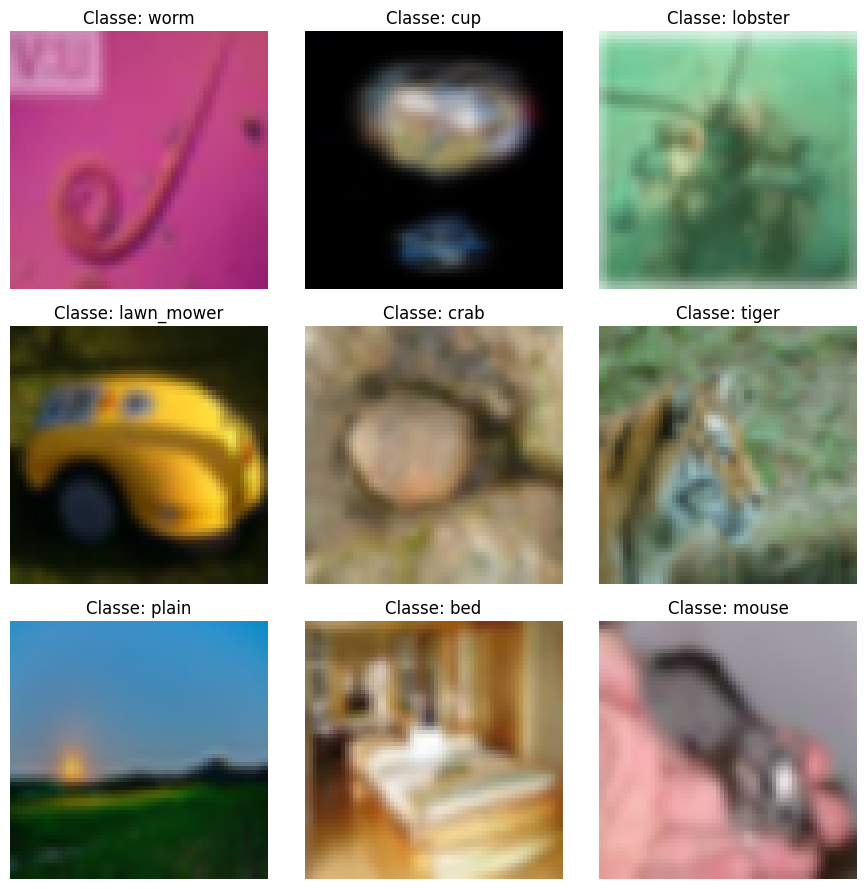

In [21]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def mostrar_grid_3x3(testset, class_names):
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    indices = random.sample(range(len(testset)), 9)

    for ax, idx in zip(axes.flat, indices):
        image, label = testset[idx]

        # Desfaz a normalização para visualização
        image = image * 0.5 + 0.5  # desfaz Normalize((0.5,...), (0.5,...))
        image_np = TF.to_pil_image(image)

        ax.imshow(image_np)
        ax.set_title(f"Classe: {class_names[label]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Exibir grid usando testset_aug
mostrar_grid_3x3(testset, testset.classes)

In [22]:
import torch
import random
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def avaliar_grupos(testset, model, device='cpu', n_execucoes=5, n_trials=100, group_size=9, min_class_count=3):
    model.eval()

    # Construir um dicionário: classe -> lista de índices
    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(testset):
        class_to_indices[label].append(idx)

    eligible_classes = [cls for cls, idxs in class_to_indices.items() if len(idxs) >= min_class_count]
    print(f"Total de classes elegíveis: {len(eligible_classes)}")

    # Acumuladores gerais
    total_predictions_all = 0
    total_correct_all = 0
    total_grupos_all = 0

    acertos_grupo_total_all = 0
    acertos_grupo_parcial_all = 0
    erros_grupo_total_all = 0

    for exec_num in range(n_execucoes):
        print(f"\n🔁 Execução {exec_num + 1}/{n_execucoes}")
        for _ in tqdm(range(n_trials), desc=f"Grupo de avaliação #{exec_num + 1}"):
            chosen_class = random.choice(eligible_classes)
            class_indices = random.sample(class_to_indices[chosen_class], min_class_count)

            remaining_indices = [i for i in range(len(testset)) if i not in class_indices]
            other_indices = random.sample(remaining_indices, group_size - min_class_count)

            group_indices = class_indices + other_indices
            random.shuffle(group_indices)

            group_class_correct = 0
            group_class_total = 0

            for idx in group_indices:
                img, label = testset[idx]
                img_input = img.unsqueeze(0).to(device)

                with torch.no_grad():
                    output = model(img_input)
                    pred = output.argmax(dim=1).item()

                total_predictions_all += 1
                if pred == label:
                    total_correct_all += 1

                if label == chosen_class:
                    group_class_total += 1
                    if pred == label:
                        group_class_correct += 1

            total_grupos_all += 1
            if group_class_correct == group_class_total:
                acertos_grupo_total_all += 1
            elif group_class_correct > 0:
                acertos_grupo_parcial_all += 1
            else:
                erros_grupo_total_all += 1

    # Resultados finais
    acc_img = total_correct_all / total_predictions_all
    acc_total = acertos_grupo_total_all / total_grupos_all
    acc_parcial = acertos_grupo_parcial_all / total_grupos_all
    erro_total = erros_grupo_total_all / total_grupos_all

    # Exibição
    print(f"\n📊 Resultados em {n_execucoes} execuções ({total_grupos_all} grupos, {total_predictions_all} imagens):")
    print(f"🔹 Acurácia média por imagem: {acc_img:.2%} ({total_correct_all}/{total_predictions_all})")
    print(f"✅ Grupos com acerto total da classe-alvo: {acc_total:.2%} ({acertos_grupo_total_all}/{total_grupos_all})")
    print(f"⚠️ Grupos com acerto parcial da classe-alvo: {acc_parcial:.2%} ({acertos_grupo_parcial_all}/{total_grupos_all})")
    print(f"❌ Grupos com erro total da classe-alvo: {erro_total:.2%} ({erros_grupo_total_all}/{total_grupos_all})")

# Exemplo de chamada:
avaliar_grupos(testset=testset_aug, model=model, device=device, n_execucoes=5)


Total de classes elegíveis: 100

🔁 Execução 1/5


Grupo de avaliação #1: 100%|█████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.42it/s]



🔁 Execução 2/5


Grupo de avaliação #2: 100%|█████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.67it/s]



🔁 Execução 3/5


Grupo de avaliação #3: 100%|█████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.57it/s]



🔁 Execução 4/5


Grupo de avaliação #4: 100%|█████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.99it/s]



🔁 Execução 5/5


Grupo de avaliação #5: 100%|█████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.15it/s]


📊 Resultados em 5 execuções (500 grupos, 4500 imagens):
🔹 Acurácia média por imagem: 68.47% (3081/4500)
✅ Grupos com acerto total da classe-alvo: 37.00% (185/500)
⚠️ Grupos com acerto parcial da classe-alvo: 55.40% (277/500)
❌ Grupos com erro total da classe-alvo: 7.60% (38/500)


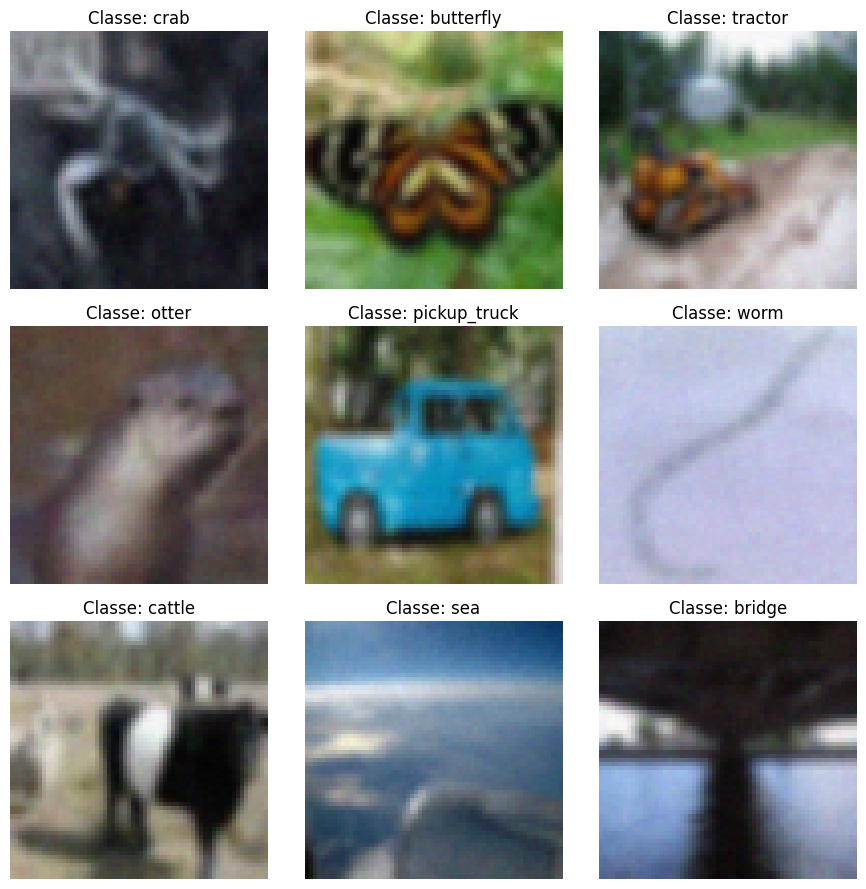

In [23]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def mostrar_grid_3x3(testset, class_names):
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    indices = random.sample(range(len(testset)), 9)

    for ax, idx in zip(axes.flat, indices):
        image, label = testset[idx]

        # Desfaz a normalização para visualização
        image = image * 0.5 + 0.5 
        image_np = TF.to_pil_image(image)

        ax.imshow(image_np)
        ax.set_title(f"Classe: {class_names[label]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Exibir grid usando testset_aug
mostrar_grid_3x3(testset_aug, testset_aug.classes)